# 1. <big>프로젝트 개요</big>

## 1.1 프로젝트 명 및 기간

### - 프로젝트 명 : <span style=color:green>네이버</span> 영화 추천 알고리즘
### - 프로젝트 기간 : `2018.01.17 ~ 2018.3 (1.5 개월)`

## 1.2 프로젝트 `목표`

### - User 에게 가장 알맞은 `추천 영화` 목록 제공

## 1.3 프로젝트 `진행 방향`


### - Sparse matrix 알고리즘을 풀기위해 matrix factorization / Deep learning 적용

텍스트에 사용되는 word2vec을 movie list를 벡터화 해서 movie2vec 을 적용해서 추천 알고리즘 구현

In [110]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pandas import pivot_table
import io

import pickle


%matplotlib inline  
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns


from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from IPython.display import SVG

import keras
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.constraints import non_neg
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Embedding, Reshape, Dot, Concatenate, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
tf.logging.set_verbosity(tf.logging.ERROR)

# from surprise import Reader, Dataset
# from surprise import SVD, evaluate
# from surprise import NMF

# 2. <big>데이터</big>

## 2-1. 데이터 `크롤링`
    - 네이버 영화 평점 사이트(https://movie.naver.com/movie/point/af/list.nhn)에서 데이터 크롤링(BeautifulSoup 이용)
    - crontab 이용(movie_crawling(server).py) 30분 간격으로 데이터 추가 및 업데이트
    - csv파일로 저장

## 2.2 데이터 `확인 / 분석`

### 데이터 불러오기
- rows : `181041`
- columns : `3(movie, name, point)`

In [68]:
df = pd.read_csv('movie_point.csv')
df = df[['movie','name','point']]
df.columns = ['title', 'user', 'rating']
df.tail()

,title,user,rating
181037,에브리타임 룩 앳 유,yhib****,9
181038,허비 행콕 : 무한한 가능성,heyh****,10
181039,뺑반,ehca****,7
181040,이스케이프 룸,ekdn****,10
181041,이스케이프 룸,klee****,7


### rating 점수 범위
- `1점 ~ 10점`




In [69]:
print('rating range :',sorted(df['rating'].unique()) )

rating range : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### User와 Movie 고유 번호 할당

In [70]:
df["user_id"] = df.user.astype('category').cat.codes.values
df["movie_id"] = df.title.astype('category').cat.codes.values
df = df[['title','user','rating','user_id','movie_id']]
df = df.reset_index()
print(len(df))
df.tail()

181042


,index,title,user,rating,user_id,movie_id
181037,181037,에브리타임 룩 앳 유,yhib****,9,64332,3701
181038,181038,허비 행콕 : 무한한 가능성,heyh****,10,22822,5715
181039,181039,뺑반,ehca****,7,16514,2614
181040,181040,이스케이프 룸,ekdn****,10,16851,4235
181041,181041,이스케이프 룸,klee****,7,33580,4235


### 각 user가 평점(rating)를 준 영화의 갯수



*   평균적으로 한명의 user는 2 ~ 3개의 영화에 별점을 주었다

*   영화 평가를 가장 많이한 사람은 총 277편에 영화 평점을 주었다




In [71]:
users_nb = df['user_id'].value_counts().reset_index()
users_nb.columns = ['user_id', 'nb_lines']
users_nb['nb_lines'].describe()

count    67306.000000
mean         2.689834
std          5.305393
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        277.000000
Name: nb_lines, dtype: float64

In [73]:
df = pd.merge(df, users_nb, on='user_id')
df.tail()

,index,title,user,rating,user_id,movie_id,nb_lines
181037,180983,범죄와의 전쟁 : 나쁜놈들 전성시대,bspx****,10,9305,2315,1
181038,180984,캡틴 마블,hull****,10,24704,4855,1
181039,181006,1919 유관순,sk30****,10,53508,31,1
181040,181012,캡틴 마블,eatt****,10,16144,4855,1
181041,181019,더 페이버릿: 여왕의 여자,sadg****,10,51195,1178,1


Text(0.5, 0, '한 user당 평점을 준 갯수')

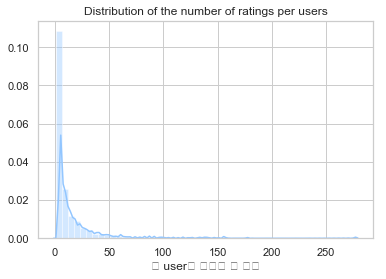

In [74]:
plt.title("Distribution of the number of ratings per users")
test_plot = sns.distplot(df['nb_lines'])
plt.xlabel('한 user당 평점을 준 갯수')
# test_plot.set_xticks(np.arange(1,20,1))

### 영화 별 point 받은 횟수

*   평균적으로 한 영화는 **30**개의 평점(rating)을 받았다 

*   평점을 가장 많이 받은 영화는 총 20081개의 평점을 받았다


In [76]:
movies_nb = df['movie_id'].value_counts().reset_index()
movies_nb.columns = ['movie_id', 'nb_movie_lines']
movies_nb['nb_movie_lines'].describe()

count     5897.000000
mean        30.700695
std        445.433033
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      20081.000000
Name: nb_movie_lines, dtype: float64

In [77]:
df = pd.merge(df, movies_nb, on='movie_id')
df = df.drop('index', 1)
df.tail()

,title,user,rating,user_id,movie_id,nb_lines,nb_movie_lines
181037,거북이는 의외로 빨리 헤엄친다,dpdd****,6,15263,355,1,1
181038,베른의 기적,zasw****,6,66255,2327,1,1
181039,사랑할 때 이야기하는 것들,cki5****,10,11310,2671,1,1
181040,고티카,liol****,10,36934,440,1,1
181041,어떤살인,wqeg****,10,62358,3598,1,1


Text(0, 0.5, '각 영화가 별점을 받은 갯수')

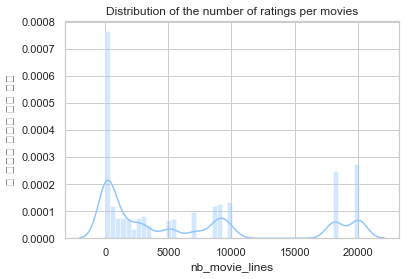

In [78]:
plt.title("Distribution of the number of ratings per movies")

sns.distplot(df['nb_movie_lines'])
plt.ylabel('각 영화가 별점을 받은 갯수')

### 각 평점별 평점 갯수

In [79]:
df_count = df.groupby('rating').size().reset_index(name = "rating_count")
df_count = df_count.set_index('rating')
df_count

,rating_count
rating,
1,22338
2,7335
3,1464
4,4393
5,3132
6,8848
7,6094
8,18430
9,10535


Text(0.5, 0, 'rating')

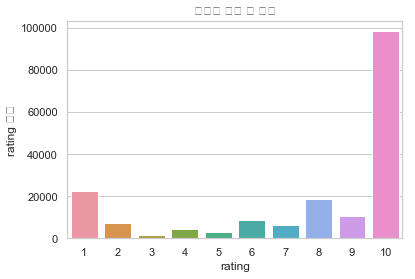

In [80]:
plt.title('평점별 평점 총 갯수')
sns.barplot(x = df_count.index, y = df_count['rating_count'])
plt.ylabel('rating 갯수')
plt.xlabel('rating')

### 평균 평점 영화 순위


In [81]:
movie_rating = pivot_table(df, values=['rating'], index=['title'],aggfunc=np.mean)
movie_rating = movie_rating.sort_values(by=['rating'], ascending=False)
movie_rating.head(20)

,rating
title,
...ing,10.0
달의 연인 - 보보경심 려,10.0
대한민국 1%,10.0
대탈주,10.0
아틀란티스 - 잃어버린 제국,10.0
아폴로 13,10.0
아프리칸 닥터,10.0
악의교전,10.0
대부업자:소울 앤 캐시,10.0


### 총 영화 데이터 갯수 : `5897`편

In [83]:
print('영화 총 갯수 :', len(df['movie_id'].unique()), '편')

영화 총 갯수 : 5897 편


### 총 user (명) 수 : `67306`명

In [85]:
print('별점을 준 총 user 수 :', len(df['user_id'].unique()), '명')

별점을 준 총 user 수 : 67306 명


### Spase matrix 인것을 알수 있다

In [87]:
print('총 user의 명수 : {}명'.format(len(df['user_id'].unique())))
print('총 영화 갯수 : {}편'.format(len(df['movie_id'].unique())))
print('총 rating 갯수 : {}({})개'.format(len(df), len(df['user_id'].unique()) * len(df['movie_id'].unique()))) 

총 user의 명수 : 67306명
총 영화 갯수 : 5897편
총 rating 갯수 : 181042(396903482)개


# 3. <big>Modeling</big>

## Matrix Low factorization을 통한 방법

 SVD(Singular Value Decomposition)




In [89]:
from surprise import SVD, Dataset, Reader, evaluate, NMF, model_selection

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']], reader)

# Singular Value Decomposition
algo = SVD()
model_selection.cross_validate(algo, data, measures=['MAE'])

{'test_mae': array([4.03025605, 4.0025141 , 4.01411224, 4.00906688, 4.0181753 ]),
 'fit_time': (14.267651796340942,
  13.877654075622559,
  17.586858987808228,
  17.11178493499756,
  15.453553199768066),
 'test_time': (0.4473710060119629,
  0.42775559425354004,
  0.7295272350311279,
  0.8428299427032471,
  0.5131990909576416)}

## Keras Deep learning을 이용한 embedding matrix를 이용한 평점 예측


In [90]:
train, test = train_test_split(df, test_size=0.2)

In [95]:
users = df.user_id.unique()
movies = df.movie_id.unique()
print("users_shape =",users.shape,"movies_shape =",movies.shape)  

users_shape = (67306,) movies_shape = (5897,)


### Model_Factorization(Dot)

In [96]:
class ModelFacto:
    
    def __init__(self, embedding_size, optimizer='adam', loss ='mae', dropout=False, dense=False):
        self.embedding_size = embedding_size
        self.optimizer = optimizer
        self.loss = loss
        self.dropout = dropout
        self.dense = dense
        
    def model_layer(self):
        # input_layer
        user_id_input = Input(shape=[1], name='user')
        item_id_input = Input(shape=[1], name='item')
        
        # embedding_layer
        user_embedding = Embedding(output_dim=self.embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
        item_embedding = Embedding(output_dim=self.embedding_size, input_dim=movies.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
        
        
            
        # flatten layer
        user_vecs = Reshape([self.embedding_size])(user_embedding)
        item_vecs = Reshape([self.embedding_size])(item_embedding)
        
        
        if self.dropout:
            user_vecs = Dropout(0.2, noise_shape=None, seed=None)(user_vecs)
            item_vecs = Dropout(0.2, noise_shape=None, seed=None)(item_vecs)

        
        # Output layer
        y = Dot(1, normalize=False)([user_vecs, item_vecs])
        
        model = Model(inputs=[user_id_input, item_id_input], outputs=y)
        
        model.compile(loss=self.loss,
                      optimizer=self.optimizer)
        return model
        
    
    def model_dense_layer(self):
        # input_layer
        user_id_input = Input(shape=[1], name='user')
        item_id_input = Input(shape=[1], name='item')
        
        # embedding_layer
        user_embedding = Embedding(output_dim=self.embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
        item_embedding = Embedding(output_dim=self.embedding_size, input_dim=movies.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
        
        
            
        # flatten layer
        user_vecs = Reshape([self.embedding_size])(user_embedding)
        item_vecs = Reshape([self.embedding_size])(item_embedding)
        
        # Dense
        user_vecs = Dense(120, activation='relu')(user_vecs)
        item_vecs = Dense(120, activation='relu')(item_vecs)
        
        if self.dropout:
            user_vecs = Dropout(0.2, noise_shape=None, seed=None)(user_vecs)
            item_vecs = Dropout(0.2, noise_shape=None, seed=None)(item_vecs)

        
        # Output layer
        y = Dot(1, normalize=False)([user_vecs, item_vecs])
        
        model = Model(inputs=[user_id_input, item_id_input], outputs=y)
        
        model.compile(loss=self.loss,
                      optimizer=self.optimizer)
        return model
    
        
        
    def summary(self):
        if self.dense:
            model = self.model_dense_layer()
        else:
            model = self.model_layer()
            
        model.summary()
        
    def svg(self):
        if self.dense:
            model = self.model_dense_layer()
        else:
            model = self.model_layer()
        return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
        
    def fit(self):
        if self.dense:
            model = self.model_dense_layer()
        else:
            model = self.model_layer()
        mainpath = '/Users/james/Documents/pyenv/tensorflow/personal_project'
        save_path = mainpath + "/models"
        mytime = time.strftime("%Y_%m_%d_%H_%M")
        modname = 'matrix_facto_{}_'.format(self.embedding_size) + mytime 
        thename = save_path + '/' + modname + '.h5'
        mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)
        
        history = model.fit([train['user_id'], train['movie_id']]
                           , train['rating']
                           , batch_size=50, epochs=10
                           , validation_split=0.1
                           , callbacks=[mcheck]
                           , shuffle=True)
        
        with open(mainpath + '/histories/' + modname + '.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

In [101]:
def loss_graph(hisotry_ls):
    mainpath = '/Users/james/Documents/pyenv/tensorflow/personal_project'
    for val in hisotry_ls:
        with open(mainpath + '/histories/' + val, 'rb') as file_pi:
            the_pickle = pickle.load(file_pi)
            plt.plot(the_pickle['loss'], label='loss_'+val[:15]+val[20:-10], linestyle='--')
            plt.plot(the_pickle['val_loss'], label='val_loss_'+val[:15]+val[20:-10])
    plt.legend()
    plt.ylim(0,10)
    
    return pd.DataFrame(the_pickle, columns=['loss', 'val_loss']).head(10).transpose()

In [93]:
model_facto_10 = ModelFacto(10,dense=True)
model_facto_10.fit()

Train on 130349 samples, validate on 14484 samples
Epoch 1/10
130349/130349 [==============================] - 42s 319us/step - loss: 2.3184 - val_loss: 2.0282
Epoch 2/10
130349/130349 [==============================] - 44s 335us/step - loss: 1.9210 - val_loss: 2.0328
Epoch 3/10
130349/130349 [==============================] - 44s 341us/step - loss: 1.6101 - val_loss: 2.1099
Epoch 4/10
130349/130349 [==============================] - 45s 349us/step - loss: 1.4133 - val_loss: 2.1498
Epoch 5/10
130349/130349 [==============================] - 46s 357us/step - loss: 1.2901 - val_loss: 2.1777
Epoch 6/10
130349/130349 [==============================] - 46s 350us/step - loss: 1.2068 - val_loss: 2.1998
Epoch 7/10
130349/130349 [==============================] - 43s 326us/step - loss: 1.1560 - val_loss: 2.1965
Epoch 8/10
130349/130349 [==============================] - 44s 334us/step - loss: 1.0826 - val_loss: 2.2076
Epoch 9/10
130349/130349 [==============================] - 35s 269us/step - 

In [97]:
model_facto_10 = ModelFacto(10,dense=True,dropout=True)
model_facto_10.fit()

Train on 130349 samples, validate on 14484 samples
Epoch 1/10
130349/130349 [==============================] - 39s 301us/step - loss: 2.4571 - val_loss: 2.0897
Epoch 2/10
130349/130349 [==============================] - 42s 320us/step - loss: 2.0485 - val_loss: 2.0872
Epoch 3/10
130349/130349 [==============================] - 42s 324us/step - loss: 1.8277 - val_loss: 2.1829
Epoch 4/10
130349/130349 [==============================] - 41s 315us/step - loss: 1.6751 - val_loss: 2.2172
Epoch 5/10
130349/130349 [==============================] - 43s 328us/step - loss: 1.5766 - val_loss: 2.2011
Epoch 6/10
130349/130349 [==============================] - 46s 354us/step - loss: 1.5082 - val_loss: 2.2465
Epoch 7/10
130349/130349 [==============================] - 35s 266us/step - loss: 1.4679 - val_loss: 2.2564
Epoch 8/10
130349/130349 [==============================] - 47s 360us/step - loss: 1.4198 - val_loss: 2.2541
Epoch 9/10
130349/130349 [==============================] - 50s 385us/step - 

,0,1,2,3,4,5,6,7,8,9
loss,2.457110,2.048535,1.827747,1.675120,1.576622,1.508159,1.467915,1.419754,1.383683,1.358901
val_loss,2.089661,2.087219,2.182950,2.217211,2.201148,2.246453,2.256449,2.254064,2.266097,2.280948


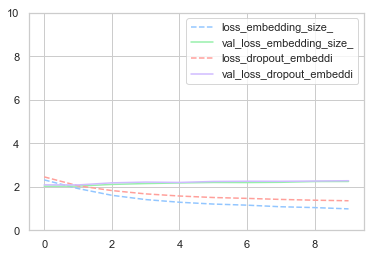

In [102]:
history_ls = ['embedding_size_10.pkl','dropout_embedding_size_10.pkl']
loss_graph(history_ls)

### Model_Factorization(Concat)

In [111]:
class ModelDense:
    
    def __init__(self, embedding_size, optimizer='adam', loss ='mae', dropout=False):
        self.embedding_size = embedding_size
        self.optimizer = optimizer
        self.loss = loss
        self.dropout = dropout
    
    def model_layer(self):
        # input_layer
        user_id_input = Input(shape=[1], name='user')
        item_id_input = Input(shape=[1], name='item')
        
        # embedding_layer
        user_embedding = Embedding(output_dim=self.embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
        item_embedding = Embedding(output_dim=self.embedding_size, input_dim=movies.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
        
        # flatten layer
        user_vecs = Reshape([self.embedding_size])(user_embedding)
        item_vecs = Reshape([self.embedding_size])(item_embedding)
        
        # Concate two layer(user_vecs, item_vecs)
        input_vecs = Concatenate()([user_vecs, item_vecs])
        
        # Dense layer
        x = Dense(128, activation='relu')(input_vecs)
        # x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        if self.dropout:
            x = Dropout(0.2, noise_shape=None, seed=None)(x)
            
        # Output layer
        y = Dense(1)(x)
        
        model = Model(inputs=[user_id_input, item_id_input], outputs=y)
        
        model.compile(loss=self.loss,
                      optimizer=self.optimizer)
        return model
    
      
    
        
        
    def summary(self):
        model = self.model_layer()
        model.summary()
        
    def svg(self):
        model = self.model_layer()
        return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
        
    def fit(self):
        model = self.model_layer()
        mainpath = '/Users/james/Documents/pyenv/tensorflow/personal_project'
        save_path = mainpath + "/models"
        mytime = time.strftime("%Y_%m_%d_%H_%M")
        modname = 'dense_{}_'.format(self.embedding_size) + mytime 
        thename = save_path + '/' + modname + '.h5'
        mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)
        
        history = model.fit([train['user_id'], train['movie_id']]
                           , train['rating']
                           , batch_size=50, epochs=10
                           , validation_split=0.1
                           , callbacks=[mcheck]
                           , shuffle=True)
        
        with open(mainpath + '/histories/' + modname + '.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

In [109]:
dense_10_128 = ModelDense(10)
dense_10_128.fit()

Train on 130349 samples, validate on 14484 samples
Epoch 1/10
130349/130349 [==============================] - 49s 377us/step - loss: 2.3128 - val_loss: 1.9837
Epoch 2/10
130349/130349 [==============================] - 47s 361us/step - loss: 1.7803 - val_loss: 2.0144
Epoch 3/10
130349/130349 [==============================] - 48s 370us/step - loss: 1.5202 - val_loss: 2.0555
Epoch 4/10
130349/130349 [==============================] - 50s 387us/step - loss: 1.3388 - val_loss: 2.0759
Epoch 5/10
130349/130349 [==============================] - 50s 386us/step - loss: 1.2287 - val_loss: 2.0991
Epoch 6/10
130349/130349 [==============================] - 51s 389us/step - loss: 1.1557 - val_loss: 2.1074
Epoch 7/10
130349/130349 [==============================] - 52s 396us/step - loss: 1.0961 - val_loss: 2.1183
Epoch 8/10
130349/130349 [==============================] - 58s 445us/step - loss: 1.0601 - val_loss: 2.0992
Epoch 9/10
130349/130349 [==============================] - 44s 337us/step - 

In [113]:
dense_10_128 = ModelDense(10, dropout=True)
dense_10_128.fit()

Train on 130349 samples, validate on 14484 samples
Epoch 1/10
130349/130349 [==============================] - 56s 428us/step - loss: 2.3963 - val_loss: 2.0118
Epoch 2/10
130349/130349 [==============================] - 46s 355us/step - loss: 2.0088 - val_loss: 2.0226
Epoch 3/10
130349/130349 [==============================] - 46s 354us/step - loss: 1.7370 - val_loss: 2.0769
Epoch 4/10
130349/130349 [==============================] - 46s 355us/step - loss: 1.5657 - val_loss: 2.0970
Epoch 5/10
130349/130349 [==============================] - 58s 448us/step - loss: 1.4553 - val_loss: 2.1345
Epoch 6/10
130349/130349 [==============================] - 67s 512us/step - loss: 1.3710 - val_loss: 2.1158
Epoch 7/10
130349/130349 [==============================] - 58s 445us/step - loss: 1.3075 - val_loss: 2.1405
Epoch 8/10
130349/130349 [==============================] - 61s 471us/step - loss: 1.2550 - val_loss: 2.2134
Epoch 9/10
130349/130349 [==============================] - 59s 453us/step - 

,0,1,2,3,4,5,6,7,8,9
loss,2.396313,2.008781,1.737041,1.565716,1.455301,1.371047,1.307469,1.254981,1.216125,1.183778
val_loss,2.011846,2.022570,2.076876,2.096982,2.134501,2.115814,2.140504,2.213368,2.158934,2.180046


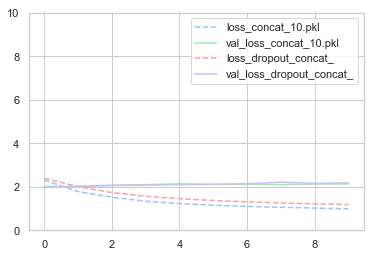

In [114]:
history_ls = ['concat_10.pkl','dropout_concat_10.pkl']
loss_graph(history_ls)

,0,1,2,3,4,5,6,7,8,9
loss,2.312789,1.780287,1.520182,1.338846,1.228739,1.155692,1.096115,1.060149,1.022418,0.987802
val_loss,1.983727,2.014449,2.055519,2.075928,2.099075,2.107441,2.118305,2.099236,2.123363,2.133741


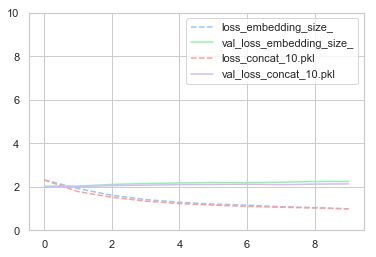

In [115]:
history_ls = ['embedding_size_10.pkl','concat_10.pkl']
loss_graph(history_ls)